In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
from plot3D import *

In [2]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

In [3]:
with h5py.File("./train_point_clouds.h5", "r") as hf:    
    a = hf["10"]
    b = a['img'][:]
    s = a['points'][:]

Text(0.5, 1.0, 'The figure 5 in 2d')

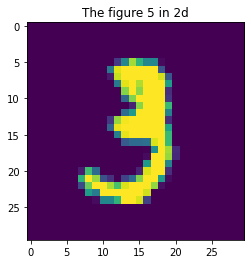

In [4]:
plt.imshow(b)
plt.title('The figure 5 in 2d')

Text(0.5, 0.92, 'The figure 5 in 3d Cloud point')

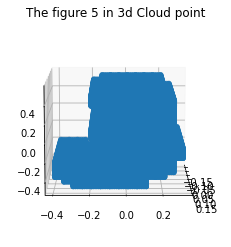

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s[:,0], s[:,1], zs=s[:,2])
ax.view_init(10, 0)
plt.title('The figure 5 in 3d Cloud point')

In [6]:
s[:,0]

array([0.15, 0.15, 0.15, ..., 0.15, 0.15, 0.15])

In [7]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.integer)
    targets_test = to_categorical(targets_test).astype(np.integer)

<ipython-input-7-780b9acdf2d2>:17: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  targets_train = to_categorical(targets_train).astype(np.integer)
<ipython-input-7-780b9acdf2d2>:18: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  targets_test = to_categorical(targets_test).astype(np.integer)


In [8]:
X_train.shape

(10000, 16, 16, 16, 3)

In [9]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=50,
            verbose=1,
            validation_split=0.3)

# Generate generalization metrics
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

C:\Users\LEGION\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 14, 14, 14, 32)    2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 7, 7, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 7, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 7, 32)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 5, 5, 64)       55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 2, 2, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 2, 64)       2

KeyboardInterrupt: 